### Inicialização (fazendo o arquivo se encotrar no repositorio)

Normalmente uso um repositório contendo material de várias diferentes cadeiras nesse caso as seguintes linhas servem para que todos os importes possam ser encontrados adequadamente.

In [17]:
import sys
import os

# Obtém o caminho do diretório do script atual
script_dir = os.getcwd()

# Adiciona o diretório pai ao caminho do sistema
sys.path.append(script_dir)

### Importando libs necessárias

In [18]:
import pygame # Nos repositórios de referência essa lib é sempre importada tendo em vista que o gymnasium (gym) utiliza a mesma, deve evitar problemas

import time # será utilizada para coletar o período temporal necessário para que algumas funções sejam executadas
from datetime import datetime

import numpy as np # numpy por motivos óbvios  

import torch # Todas as redes neurais serão criados utilizando PyTorch
import torch.nn as nn
import torch.optim as optim


import matplotlib.pyplot as plt # Demonstração de Gráficos e imagens 

1 - importando os modulos DQN e de edição de imagens

2 - inicializando o pytorch com CPU ou GPU caso a mesma esteja disponível 

In [3]:
from modelos import dqn_models
from wrappers.atari_wrappers import *

import gymnasium as gym

# verifica a disponibilidade da GPU
if torch.cuda.is_available():
    is_gpu = torch.device("cuda")
else:
    is_gpu = torch.device("cpu")

torch.set_default_device(is_gpu) # instanciando onde a rede neural deve rodar 

### importando as classes auxiliares

In [4]:
from DQN_aux.DQN_aux import *

In [5]:
# Baseada na minha versão (Pablo)
def record_video_q_neuralnet(env_name, qnet, episodes=3, folder='videos/', prefix='rl-video', epsilon=0.0):
    """
    Grava um vídeo a partir de uma política epsilon-greedy definida pela 'qtable' e pelo valor de 'epsilon'.
    - env_name: A string do ambiente cadastrada no gymnasium ou uma instância da classe. Ao final, o ambiente é fechado (função `close()`).
    - qnet: A rede neural que representa a função Q.
    - episodes: Número de episódios completos que serão executados.
    - prefiz: Prefixo do nome dos arquivos de vídeo.
    - folder: Pasta onde os arquivos de vídeo serão salvos.
    - epsilon: Valor do parâmetro da política "epsilon-greedy" usada para escolher as ações.
    """
    if isinstance(env_name, str):
        env = gym.make(env_name, render_mode="rgb_array")
    else:
        env = env_name
    rec_env = gym.wrappers.RecordVideo(env, folder, episode_trigger=lambda i : True, name_prefix=prefix)
    num_steps = 0
    for epi in range(episodes):
        state, _ = rec_env.reset()
        num_steps += 1
        epi_reward = 0.0
        done = False
        while not done:
            action = choose_action(qnet, env, state, epsilon)
            state, r, termi, trunc, _ = rec_env.step(action)
            done = termi or trunc
            num_steps += 1
            epi_reward += r
        print(f"Episode {epi}: {num_steps} steps / return {epi_reward:.2f}")
    rec_env.close()
    env.close()

In [6]:
def DQN_TRAIN(env, env_name, gamma, qnet, qnet_lr, target_qnet, target_update_freq, replay_size, batch_size, epsilon_f, epsilon_decay_period, NUM_STAPS):

    """
    Treina um agente utilizando o algoritmo Deep Q-Network (DQN) em um ambiente de aprendizado por reforço.

    Args:
        env: O ambiente de aprendizado por reforço. Pode ser uma instância da classe do ambiente ou uma string 
            que representa o nome do ambiente registrado no Gym.
        env_name (str): O nome do ambiente (usado para fins de logging e salvamento).
        gamma (float): O fator de desconto para recompensas futuras.
        qnet (torch.nn.Module): A rede neural que representa a função Q.
        qnet_lr (float): A taxa de aprendizado para o otimizador Adam utilizado para treinar a rede neural.
        target_qnet (torch.nn.Module): A rede neural que representa a função Q-alvo.
        target_update_freq (int): A frequência com que os pesos da rede alvo são atualizados.
        replay_size (int): O tamanho do buffer de experiência usado para amostragem durante o treinamento.
        batch_size (int): O tamanho do lote usado para atualizar os pesos da rede neural.
        epsilon_f (float): O valor inicial de epsilon para a política epsilon-greedy.
        epsilon_decay_period (int): O período de decaimento para o valor de epsilon.
        NUM_STAPS (int): O número total de passos de treinamento a serem executados.
    """

    # Cria o otimizador, que vai fazer o ajuste dos pesos da 'qnet',
    # Usa uma técnica de gradiente descendente de destaque, chamada ADAM
    optimizer = optim.Adam(qnet.parameters(), lr=qnet_lr)

    # Para o logging de dados, para serem exibidos no tensorboard
    writer = SummaryWriter(comment="-" + env_name)

    buffer = DQNExperienceBuffer(replay_size)

    start_time_str = datetime.now().strftime("%Y-%m-%d,%H-%M-%S")
    episode_reward_list = []
    step = 0
    epsilon = 1.0

    state, _ = env.reset()
    episode_reward = 0.0
    episode_start_step = 0
    episode_start_time = time.time()

    while True:
        step += 1

        # Decaimento linear do epsilon
        epsilon = max(epsilon_f, 1.0 - step / epsilon_decay_period)

        action = choose_action(qnet, env, state, epsilon)

        # Faz um passo / Aplica uma ação no ambiente
        new_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        episode_reward += reward

        # Adiciona no buffer
        buffer.append(state, action, reward, terminated, new_state)
        state = new_state

        if done:
            episode_reward_list.append(episode_reward)
            speed = (step - episode_start_step) / (time.time() - episode_start_time + 0.00001)

            state, _ = env.reset()
            episode_reward = 0.0
            episode_start_step = step
            episode_start_time = time.time()

            # Abaixo, faz vários loggings de dados
            mean_reward = np.mean(episode_reward_list[-100:])
            print(f"{step}: finished {len(episode_reward_list)} episodes, mean reward {mean_reward:.3f}, eps {epsilon:.2f}, speed {speed:.2f} steps/s")
            writer.add_scalar("epsilon", epsilon, step)
            writer.add_scalar("epi_reward_100", mean_reward, step)
            writer.add_scalar("epi_reward", episode_reward, step)

            # Testa se "resolveu" o ambiente
            if step > NUM_STAPS:
                print(f"Solved in {step} steps with mean reward {mean_reward:.3f}")
                # Verifica se o diretório existe e, se não, cria-o
                model_dir = 'models/' + env_name
                if not os.path.exists(model_dir):
                    os.makedirs(model_dir)
                filename = model_dir + "-" + start_time_str + ".dat"
                torch.save(qnet.state_dict(), filename)
                print(f"Model saved as {filename}") 
                break

        if len(buffer) < replay_size:
            continue

        # Faz a 'tgt_net' receber os mesmos valores de pesos da 'qnet', na frequência indicada
        if step % target_update_freq == 0:
            target_qnet.load_state_dict(qnet.state_dict())

        # Escolhendo amostras aleatórios do buffer e faz uma atualização dos pesos da rede
        optimizer.zero_grad()
        batch = buffer.sample(batch_size)
        loss_t = calc_loss(batch, qnet, target_qnet, gamma)
        loss_t.backward()
        optimizer.step()

    writer.close()
    return episode_reward_list

In [7]:
# Veja outros em: https://gymnasium.farama.org/environments/atari/
# Se mudar o jogo, lembre-se de alterar também o GOAL_REWARD abaixo!
ATARI_ENV_NAME = "ALE/SpaceInvaders-v5"

# Recompensa alvo; no Pong, esta é a diferença de pontos do player para a "cpu", sendo +21.0 o máximo e -21.0 o mínimo
# Tente com algum valor negativo (e.g. -15.0) para um treinamento mais rápido, ou algum valor positivo (+15.0) para ver o agent ganhar da "cpu"
NUM_STAPS = 10_000 #0.0

# Parâmetros do DQN
GAMMA = 0.99
BATCH_SIZE = 32
REPLAY_SIZE = 20_000
LEARNING_RATE = 1e-4
SYNC_TARGET_FRAMES = 1_500

EPSILON_DECAY_PERIOD = 100_000
EPSILON_FINAL = 0.02

N_STAPS_FOR_OBS = 4

env2 = gym.make(ATARI_ENV_NAME)

In [8]:
# Aplica os wrappers do DQN para ambientes Atari
env2a = MaxAndSkipEnv(env2)
env2b = FireResetEnv(env2a)
env2c = ProcessFrame84(env2b)
env2d = ImageToPyTorch(env2c)
env2e = BufferWrapper(env2d, N_STAPS_FOR_OBS)
env2f = ScaledFloatFrame(env2e)

# Cria as redes neurais
qnet2 = dqn_models.DQNNet(env2f.observation_space.shape, env2f.action_space.n)
qtarget2 = dqn_models.DQNNet(env2f.observation_space.shape, env2f.action_space.n)

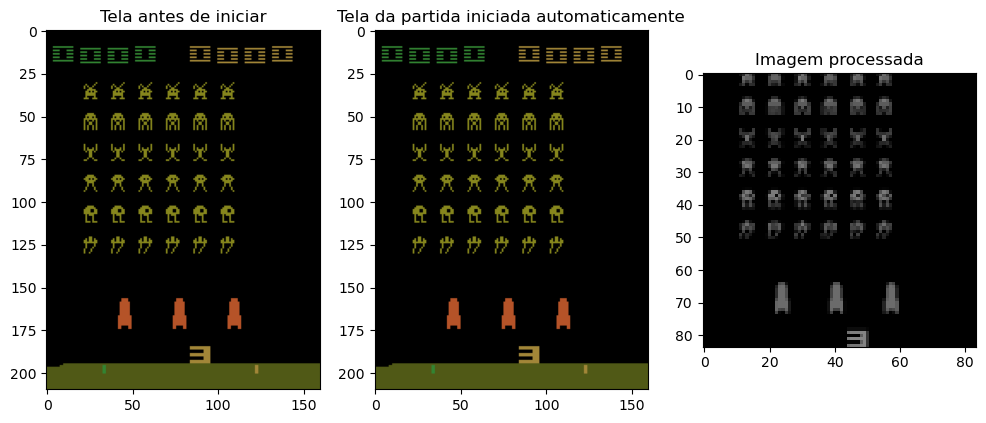

In [9]:
# Mostrando a tela do ambiente original, e outras telas após passar por alguns wrappers
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,5))

s, _ = env2.reset()
ax1.imshow(s)
ax1.set_title('Tela antes de iniciar')

s, _ = env2b.reset()
ax2.imshow(s)
ax2.set_title('Tela da partida iniciada automaticamente')

s, _ = env2d.reset()
ax3.imshow(s[0], cmap='gray', vmin=0, vmax=255)  # exibe em escala de cinza
ax3.set_title('Imagem processada');

In [10]:
lisat_fim = DQN_TRAIN(
    env = env2f,
    env_name = ATARI_ENV_NAME,
    gamma = GAMMA,
    qnet = qnet2,
    qnet_lr = LEARNING_RATE,
    target_qnet = qtarget2,
    target_update_freq = SYNC_TARGET_FRAMES,
    replay_size = REPLAY_SIZE,
    batch_size = BATCH_SIZE,
    epsilon_f = EPSILON_FINAL,
    epsilon_decay_period = EPSILON_DECAY_PERIOD,
    NUM_STAPS = NUM_STAPS)
    

112: finished 1 episodes, mean reward 80.000, eps 1.00, speed 374.89 steps/s
237: finished 2 episodes, mean reward 105.000, eps 1.00, speed 252.50 steps/s
386: finished 3 episodes, mean reward 106.667, eps 1.00, speed 321.81 steps/s
593: finished 4 episodes, mean reward 186.250, eps 0.99, speed 354.66 steps/s
699: finished 5 episodes, mean reward 160.000, eps 0.99, speed 323.13 steps/s
820: finished 6 episodes, mean reward 157.500, eps 0.99, speed 317.58 steps/s
913: finished 7 episodes, mean reward 142.857, eps 0.99, speed 319.58 steps/s
993: finished 8 episodes, mean reward 125.625, eps 0.99, speed 311.48 steps/s
1182: finished 9 episodes, mean reward 140.000, eps 0.99, speed 320.59 steps/s
1354: finished 10 episodes, mean reward 143.500, eps 0.99, speed 365.96 steps/s
1592: finished 11 episodes, mean reward 181.818, eps 0.98, speed 340.95 steps/s
1744: finished 12 episodes, mean reward 179.583, eps 0.98, speed 324.77 steps/s
1866: finished 13 episodes, mean reward 173.462, eps 0.98,

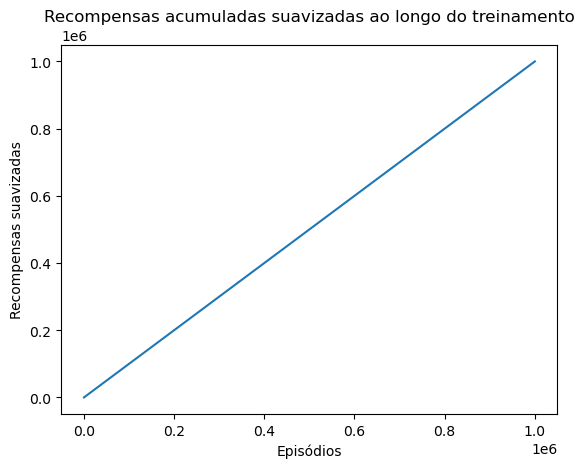

In [16]:

# Calculando a média móvel com uma janela de 100 episódios
janela = 200
lisat_fim = [x for x in range(0,1000000)]
recompensas_suavizadas = np.convolve(lisat_fim, np.ones(janela)/janela, mode='valid')

# Criando uma lista de episódios para o eixo x
episodios = list(range(janela, janela + len(recompensas_suavizadas)))

# Plotando o gráfico das recompensas suavizadas ao longo do tempo
plt.plot(episodios, recompensas_suavizadas)
plt.title('Recompensas acumuladas suavizadas ao longo do treinamento')
plt.xlabel('Episódios')
plt.ylabel('Recompensas suavizadas')
plt.show()